# Tutorial on collecting DFT Features
* Fall 2022 Coding Camp by Liliana C. Gallegos
* Utilizes DISCO python script to parse through Gaussian NBO and GIAO output files.
* Collects NBO charges, NMR chemical shift values, bond distances, HOMO/LUMO molecular properties.

In [1]:
## Basic imports
import os, sys, re, time, subprocess
import glob, csv
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

## DFT features
import DISCO as cd

## Rdkit 
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import SDMolSupplier 

In [2]:
## Working path
wdir = '/home/liliana/projects/Coding-camp-tutorials/2022-Fall_run-collect-dft-features/'   
os.chdir(wdir)

# I. Simple examples

In [3]:
## Load smiles
csv = 'molecule_smiles.csv' 
reactants = pd.read_csv(csv)

In [6]:
## DFT output files
nbo_logs = sorted(glob.glob('outputs/*_NBO.log'))
nmr_logs = sorted(glob.glob('outputs/*NMR.log'))
# print('o Total number of log files: {} '.format(len(logs)))
print('Total number of NBO log files: {} '.format(len(nbo_logs)))
print('Total number of NMR log files: {} '.format(len(nmr_logs)))

Total number of NBO log files: 5 
Total number of NMR log files: 5 


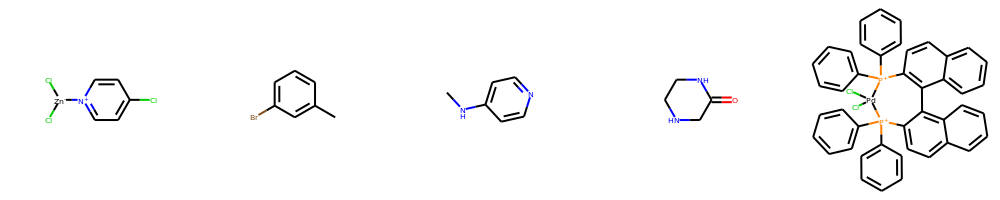

In [5]:
mols = [ Chem.MolFromSmiles(smi) for smi in reactants['Smile'] ]
Chem.Draw.MolsToGridImage(mols, molsPerRow=5)

- Atoms of interest at the reaction center: N, Pd-metal, and ipso-Carbon atoms
- For aryls: ipso-Carbons with C-X halogen bonds. 
- For amines: if multiple N-atoms with N-H bonds, prioritizes SP3 N-atoms then most negativily charged N-atoms.


## (a) Collecting Bond Distances
- Use log or xyz file and distance option: distance=(atom1,atom2)
- For atom index of bonded atoms: .Bonded_atoms
- For bond distance: .Dist

In [7]:
#### Single bond occurance
mol1 = nbo_logs[0]
dist = cd.disco(mol1, distance='Cl,C')

ClC_atom_number = dist.Bonded_atoms[0]
ClC_distance = round(dist.Dist[0], 2)

print('Bond distance for {} = {} A'.format(ClC_atom_number, ClC_distance))

Bond distance for ['3C', '11Cl'] = 1.73 A


In [8]:
#### Multiple bond occurance
mol4 = nbo_logs[3]
dist = cd.disco(mol4, distance='N,H')

for ab_bond, length in zip(dist.Bonded_atoms, dist.Dist):
    print('Bond distance for {} = {} A'.format(ab_bond, round(length,2)))

Bond distance for ['3N', '8H'] = 1.01 A
Bond distance for ['6N', '15H'] = 1.01 A


## (b) Collecting HOMO and LUMO values

- Use NBO computed (*log) file and molecular orbital option: mo=True
- For HOMO value: .HOMO
- For LUMO value: .LUMO

In [9]:
#### Molecular features: HOMO and LUMO
feats_mol1 = cd.disco(mol1, mo=True)  

print('HOMO value = ', feats_mol1.HOMO[0])
print('LUMO value = ', feats_mol1.LUMO[0])

HOMO value =  -0.3698
LUMO value =  -0.017


## (c) Collecting atomic NBO charges

- Use NBO computed (*log) file and charge option can be specified by atom number and/or element (e.g., '6', 'N', '6N'): charge=(atom1)
- For element and atom index: .Atom
- For atomic charge value: .Chrg  

In [10]:
#### Atomic charges
Catom, Clatom = ClC_atom_number
Natom  = 'N' 
C2atom = '4'

feats_C  = cd.disco(mol1, charge=Catom)    #### charge at C atom
feats_Cl = cd.disco(mol1, charge=Clatom)   #### charge at Cl atom
feats_N  = cd.disco(mol1, charge=Natom)    #### charge at N atom
feats_C2 = cd.disco(mol1, charge=C2atom)   #### charge at ortho-C atom

print('Atom charge at {} = {}'.format(feats_C.Atom[0], feats_C.Chrg[0]))
print('Atom charge at {} = {}'.format(feats_Cl.Atom[0], feats_Cl.Chrg[0]))
print('Atom charge at {} = {}'.format(feats_N.Atom[0], feats_N.Chrg[0]))
print('Atom charge at {} = {}'.format(feats_C2.Atom[0], feats_C2.Chrg[0]))

Atom charge at 3C = 0.0343
Atom charge at 11Cl = 0.03797
Atom charge at 6N = -0.66961
Atom charge at 4C = -0.26068


## (c) Collecting NMR tensor values

- Use log file and nmr option can be specified by atom number and/or element (e.g., '6', 'N', '6N'): nmr=(atom1)
- For atomic NMR tensor values: .NMR 

In [11]:
mol1_nmr = nmr_logs[0]
mol2_nmr = nmr_logs[1]

feats_mol1_nmrC = cd.disco(mol1_nmr, nmr=Catom)  
feats_mol2_nmrC = cd.disco(mol2_nmr, nmr='2') 

print('NMR tensor value at {} for mol1 = {}'.format(feats_mol1_nmrC.Atom[0], feats_mol1_nmrC.NMR[0]))
print('NMR tensor value at {} for mol2 = {}'.format(feats_mol2_nmrC.Atom[0], feats_mol2_nmrC.NMR[0]))

NMR tensor value at 3C for mol1 = 24.4286
NMR tensor value at 2C for mol2 = 43.0757


- Use scale option for chemical shift values: scale=(intercept,slope)

In [12]:
#### Scaled values for 13C NMR shield values
#### http://cheshirenmr.info/ScalingFactors.htm
feats_mol1_nmrC = cd.disco(mol1_nmr, nmr=Catom, scale='185.6667,-1.0303')  
feats_mol2_nmrC = cd.disco(mol2_nmr, nmr='2', scale='185.6667,-1.0303') 

print('13C NMR value at {} for mol1 = {} ppm'.format(feats_mol1_nmrC.Atom[0], round(feats_mol1_nmrC.NMR[0],1)))
print('13C NMR value at {} for mol2 = {} ppm'.format(feats_mol2_nmrC.Atom[0], round(feats_mol2_nmrC.NMR[0],1)))

13C NMR value at 3C for mol1 = 156.5 ppm
13C NMR value at 2C for mol2 = 138.4 ppm


# II. High-throughput workflow

In [13]:
#### csv dataframe
print(reactants.shape)
reactants.head()

(5, 3)


,Name,Smile,Bond
0,mol1,ClC1=CC=[N+]([Zn-](Cl)Cl)C=C1,"Cl,C"
1,mol2,Cc1cc(Br)ccc1,"Br,C"
2,mol3,CNc1ccncc1,"N,H"
3,mol4,O=C1CNCCN1,"N,H"
4,mol5,Cl[Pd]1(Cl)[P+](c2ccccc2)(c2ccccc2)c2ccc3ccccc...,"Pd,P"


In [14]:
def log2mol(log_file):
    ''' Converts log files into mol files. Obabel doesnt work all the time. '''
    name, ext = os.path.splitext(log_file)
    
    obabel_command = ['obabel', '-ig16', f'{log_file}', '-osdf', '-O', f'{name}.mol']
    subprocess.call(obabel_command)
    
    if os.path.exists(f'{name}.mol'): mol_file = f'{name}.mol'
    else: mol_file = 'None'
    return mol_file

def BasicNatom(mol):
    ''' 
    Find basic Nitrogen atom if multiple Nitrogens with N-H. 
    Prioritizes (i) SP3 Nitrogen atoms then (ii) most negativily charged. 
    Returns: Nitrogen atom index.
    '''
    #mol = Chem.MolFromSmiles(smile)
    Chem.ComputeGasteigerCharges(mol)
    Nconnectivity = mol.GetSubstructMatches(Chem.MolFromSmarts('[D{-2}]'))
    Nbasic = []
    #### (i) Find SP3 Nitrogen atom
    for i, atom in enumerate(mol.GetAtoms()):
        ###atom.SetProp("molAtomMapNumber", str(atom.GetIdx()))
        for N in Nconnectivity :
            if atom.GetAtomicNum() == 7 and atom.GetIdx() == N[0] and atom.GetHybridization()==Chem.rdchem.HybridizationType.SP3:
                Nbasic.append(atom.GetIdx())
                ###print(f'N{atom.GetIdx()}:', round(mol.GetAtomWithIdx(atom.GetIdx()).GetDoubleProp('_GasteigerCharge'),4), atom.GetHybridization())
    #### (ii) Find most Negative Nitrogen atom
    if len(Nbasic) > 1:
        Ncharge = [ mol.GetAtomWithIdx(atom).GetDoubleProp('_GasteigerCharge') for i, atom in enumerate(Nbasic)]
        Nindx = Nbasic[Ncharge.index(min(Ncharge))]
    else: Nindx = Nbasic[0]
    return Nindx+1

In [15]:
nbo_files, atom1_chrg, atom1, bond_distance, lumo, homo = [], [], [], [], [], [] 
nmr_files, atom1_nmr = [], []

start = time.time()
for i, (rxt, smi, bond) in enumerate(zip(reactants['Name'], reactants['Smile'], reactants['Bond'])):
    #print(i, rxt, bond)
    for log in sorted(nbo_logs):
        if log.find(rxt) > -1:
            
            #### Bond distance 
            dist = cd.disco(log, distance=bond)
            
            #### Assign atom 1
            atom1s = [ a if re.split('(\d+)',a)[-1] in ['C', 'N', 'Pd'] else b for a, b in dist.Bonded_atoms ]
            
            #### If multiple N atoms, then find basic and electronegative Nitrogen atom (for amines)
            if len(atom1s) > 1 and atom1s[0].find('N') > -1:
                mol_file = log2mol(log)
                mol = Chem.SDMolSupplier(mol_file)[0]
                smi = Chem.MolToSmiles(mol)
                atom1s = [str(BasicNatom(mol))]
            
            #### Molecular properties: HOMO, LUMO
            #### Atomic charge
            feats_nbo = cd.disco(log, mo=True, charge=atom1s[0])
            nbo_files.append(rxt); homo.append(feats_nbo.HOMO[0]); lumo.append(feats_nbo.LUMO[0])
            atom1_chrg.append(feats_nbo.Chrg[0]); atom1.append(feats_nbo.Atom[0]); bond_distance.append(dist.Dist[0])
    
    for log2 in sorted(nmr_logs):
        if log2.find(rxt) > -1:
            
            #### Atomic NMR tensor value
            feats_nmr = cd.disco(log2, nmr=atom1s[0])
            nmr_files.append(rxt); atom1_nmr.append(feats_nmr.NMR[0])   
            
print('Total Time Collecting DFT features for {} log files = {} secs \n'.format(len(nmr_files)+len(nbo_files), round(time.time() - start,2)))

Total Time Collecting DFT features for 10 log files = 0.07 secs 



# III. Tabulate all features

In [16]:
nbo_df = pd.DataFrame({ 'Name': nbo_files, 'Atom1': atom1, 'Atom1 charge':atom1_chrg, 'LUMO': lumo, 'HOMO': homo, 'Bond Distance': bond_distance }) 
nmr_df = pd.DataFrame({ 'Name': nmr_files, 'Atom1 nmr':atom1_nmr })
feats_df = reactants.merge(nbo_df, on=['Name']).merge(nmr_df, on=['Name'])
feats_df.head()

,Name,Smile,Bond,Atom1,Atom1 charge,LUMO,HOMO,Bond Distance,Atom1 nmr
0,mol1,ClC1=CC=[N+]([Zn-](Cl)Cl)C=C1,"Cl,C",3C,0.03430,-0.0170,-0.3698,1.73220,24.4286
1,mol2,Cc1cc(Br)ccc1,"Br,C",2C,-0.07746,0.0506,-0.3175,1.90708,43.0757
2,mol3,CNc1ccncc1,"N,H",1N,-0.60228,0.0651,-0.2885,1.00521,187.6657
3,mol4,O=C1CNCCN1,"N,H",6N,-0.68712,0.1032,-0.3102,1.00876,216.7489
4,mol5,Cl[Pd]1(Cl)[P+](c2ccccc2)(c2ccccc2)c2ccc3ccccc...,"Pd,P",2Pd,0.43299,-0.0343,-0.2973,2.30633,-178.0082


# IV. Visualize feature distribution

In [17]:
from sklearn.preprocessing import StandardScaler

#### Scaled data
scaler = StandardScaler()
feats_num  = feats_df.select_dtypes(include=np.number)

feats_scaled = pd.DataFrame(scaler.fit_transform(feats_num), columns=feats_num.columns)
print(feats_scaled.shape)

(5, 5)


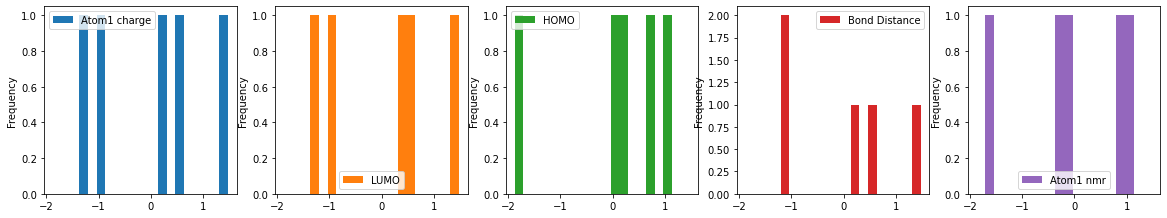

In [18]:
feats_scaled.plot.hist(subplots=True, layout=(5,5), figsize=(20, 20), bins=20);